In [1]:
import os
import sys
import time
import glob
import tables as tb
import pandas as pd
import numpy  as np

os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit
import hist

from invisible_cities.core.system_of_units import kg, dalton, year, mBq, m3, mm
from invisible_cities.evm.mixer            import get_file_number

from invisible_cities.io.dst_io            import load_dst, load_dsts
from invisible_cities.database.load_db     import RadioactivityData

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(


In [2]:
get_isotope_name  = lambda name: name.split("/")[-5]
get_g4volume_name = lambda name: name.split("/")[-4] 

def load_tracks_with_file_number(filenames, max_nevents=1e10):
    
    nevents = 0
    tracks = pd.DataFrame()
    for f, filename in enumerate(filenames, 1):
        try:
            tracks_ = pd.read_hdf(filename, f"Tracking/Tracks")
        except:
            #print(filename)
            continue
        # energy cut
        energies = tracks_.groupby(level=0).energy.sum()
        sel = (2.40 <= energies)
        tracks_ = tracks_.loc[sel]
        tracks_["file"] = get_file_number(filename)
        tracks = pd.concat([tracks, tracks_])

        nevents += tracks_.event.nunique()        
        if nevents >= max_nevents:
            break
    return tracks


def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    if not sel_spurious.any(): return tracks.reset_index("trackID")
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks

In [3]:
act_df, mceff_df = RadioactivityData("next100")
iceff_df = pd.read_csv("../efficiencies_ic.csv")

index = ["Isotope", "G4Volume"]
iceff_df = iceff_df.set_index(index)
act_df   =   act_df.set_index(index)
mceff_df = mceff_df.set_index(index)

iceff_df["exposure"] = ((iceff_df.nsim/(mceff_df.MCEfficiency*act_df.TotalActivity * mBq))/year)

In [4]:
path = os.path.expandvars("$HOME/NEXT/DATA/production/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

t0 = time.time()
filenames = glob.glob(path.format(isotope="0nubb", g4volume="*"))
tracks_0nubb = load_tracks_with_file_number(filenames).set_index(["event", "file"])
print("Time (min):", (time.time()-t0) / 60)

# t0 = time.time()
# filenames = glob.glob(path.format(isotope="2nubb", g4volume="*"))
# tracks_2nubb = load_tracks_with_file_number(filenames, 1e10).set_index(["event", "file"])
# print("Time (min):", (time.time()-t0) / 60)

Time (min): 0.2810316642125448


In [5]:
t0 = time.time()

isotope = "208Tl"
volumes = act_df.loc[isotope].index
max_nevents_per_vol = 1e10

tracks_208Tl = pd.DataFrame()
for i, volume in enumerate(volumes, 1):
    print(f"Processing {volume} ({i}/{len(volumes)})", end="\r")
    filenames = glob.glob(path.format(isotope=isotope, g4volume=volume))
    tracks_ = load_tracks_with_file_number(filenames, max_nevents_per_vol).set_index(["event", "file"])
    if len(tracks_) == 0:
        continue
    tracks_.loc[:, "G4Volume"] = volume
    tracks_208Tl = pd.concat([tracks_208Tl, tracks_])
print()  
print("Time (min):", (time.time()-t0) / 60)

Processing VESSEL (20/20)E (19/20))
Time (min): 19.268021353085835


In [6]:
t0 = time.time()

isotope = "214Bi"
volumes = act_df.loc[isotope].index
max_nevents_per_vol = 1e10

tracks_214Bi = pd.DataFrame()
for i, volume in enumerate(volumes, 1):
    print(f"Processing {volume} ({i}/{len(volumes)})", end="\r")
    filenames = glob.glob(path.format(isotope=isotope, g4volume=volume))
    tracks_ = load_tracks_with_file_number(filenames, max_nevents_per_vol).set_index(["event", "file"])
    if len(tracks_) == 0:
        continue
    tracks_.loc[:, "G4Volume"] = volume
    tracks_214Bi = pd.concat([tracks_214Bi, tracks_])
print() 
print("Time (min):", (time.time()-t0) / 60)

Processing VESSEL (20/20)E (19/20))
Time (min): 3.4902989506721496


In [7]:
spurious_energy = 0.01

# remove spurious
tracks_0nubb = remove_spurious_tracks(tracks_0nubb, spurious_energy)
# tracks_2nubb = remove_spurious_tracks(tracks_2nubb, spurious_energy)
tracks_214Bi = remove_spurious_tracks(tracks_214Bi, spurious_energy)
tracks_208Tl = remove_spurious_tracks(tracks_208Tl, spurious_energy)

tracks_208Tl = tracks_208Tl.set_index("G4Volume", append=True)
tracks_214Bi = tracks_214Bi.set_index("G4Volume", append=True)

In [8]:
# add volume weights
weights = act_df.TotalActivity * mceff_df.MCEfficiency

tracks_208Tl = tracks_208Tl.reset_index().set_index("G4Volume")
tracks_208Tl.loc[:, "weights"] = weights.loc["208Tl"]
tracks_208Tl = tracks_208Tl.reset_index().set_index(["event", "file", "G4Volume"])

tracks_214Bi = tracks_214Bi.reset_index().set_index("G4Volume")
tracks_214Bi.loc[:, "weights"] = weights.loc["214Bi"]
tracks_214Bi = tracks_214Bi.reset_index().set_index(["event", "file", "G4Volume"])

## 1 track + no-overlap selection

In [9]:
sel_0nubb = (tracks_0nubb.numb_of_tracks == 1) & (tracks_0nubb.ovlp_blob_energy == 0)
# sel_2nubb = (tracks_2nubb.numb_of_tracks == 1) & (tracks_2nubb.ovlp_blob_energy == 0)
sel_208Tl = (tracks_208Tl.numb_of_tracks == 1) & (tracks_208Tl.ovlp_blob_energy == 0)
sel_214Bi = (tracks_214Bi.numb_of_tracks == 1) & (tracks_214Bi.ovlp_blob_energy == 0)

tracks_0nubb = tracks_0nubb.loc[sel_0nubb]
# tracks_2nubb = tracks_2nubb.loc[sel_2nubb]
tracks_208Tl = tracks_208Tl.loc[sel_208Tl]
tracks_214Bi = tracks_214Bi.loc[sel_214Bi]

# selections_df.loc["0nubb", "track"] = sel_0nubb.sum()
# selections_df.loc["2nubb", "track"] = sel_2nubb.sum()

# a = tracks_208Tl[sel_208Tl].G4Volume.value_counts()
# selections_df.loc[("208Tl", a.index), "track"] = a.values

# a = tracks_214Bi[sel_214Bi].G4Volume.value_counts()
# selections_df.loc[("214Bi", a.index), "track"] = a.values

## Energy cut

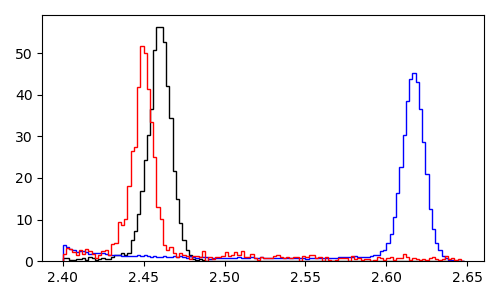

In [10]:
bins=np.arange(2.4, 2.65, 0.002)

plt.figure(figsize=[5, 3])
plt.hist(tracks_0nubb.energy, bins=bins, color="k", label="0nubb", density=True, histtype="step")
# plt.hist(tracks_2nubb.energy, bins=bins, color="g", label="2nubb", density=True, histtype="step")
plt.hist(tracks_208Tl.energy, bins=bins, color="b", label="208Tl", weights=tracks_208Tl.weights, density=True, histtype="step")
plt.hist(tracks_214Bi.energy, bins=bins, color="r", label="214Bi", weights=tracks_214Bi.weights, density=True, histtype="step")
plt.tight_layout()

In [11]:
emin, emax = 2.4, 2.65

sel_0nubb = (emin<tracks_0nubb.energy) & (tracks_0nubb.energy<emax)
sel_208Tl = (emin<tracks_208Tl.energy) & (tracks_208Tl.energy<emax)
sel_214Bi = (emin<tracks_214Bi.energy) & (tracks_214Bi.energy<emax)

tracks_0nubb = tracks_0nubb.loc[sel_0nubb]
tracks_208Tl = tracks_208Tl.loc[sel_208Tl]
tracks_214Bi = tracks_214Bi.loc[sel_214Bi]

## Fiducial cut

In [11]:
rmax = 450
zmin, zmax = 20, 1180

sel_0nubb = (tracks_0nubb.r_max<450) & (zmin<tracks_0nubb.z_min) & (tracks_0nubb.z_max<zmax)
sel_208Tl = (tracks_208Tl.r_max<450) & (zmin<tracks_208Tl.z_min) & (tracks_208Tl.z_max<zmax)
sel_214Bi = (tracks_214Bi.r_max<450) & (zmin<tracks_214Bi.z_min) & (tracks_214Bi.z_max<zmax)

### Energy

In [13]:
ebw = 0.001
emin, emax = 2.40, 2.65
bins = np.arange(emin, emax, ebw)
binc = (bins[1:] + bins[:-1])/2.
energy_obs_ext = zfit.Space("energy", limits=(emin, emax))
energy_obs     = zfit.Space("energy", limits=(2.42, 2.64))

h, _ = np.histogram(tracks_0nubb.loc[sel_0nubb].energy.values, bins=bins)
h    = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
pdf  = zfit.pdf.HistogramPDF(h)
data = zfit.Data.from_numpy (obs=energy_obs_ext, array=binc, weights=h)
pdf_energy_0nubb = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth=ebw)


h, _ = np.histogram(tracks_214Bi.loc[sel_214Bi].energy.values, bins=bins, weights=tracks_214Bi.loc[sel_214Bi].weights.values)
h    = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
pdf  = zfit.pdf.HistogramPDF(h)
data = zfit.Data.from_numpy (obs=energy_obs_ext, array=binc, weights=h)
pdf_energy_214Bi = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth=ebw)


h, _ = np.histogram(tracks_208Tl.loc[sel_208Tl].energy.values, bins=bins, weights=tracks_208Tl.loc[sel_208Tl].weights.values)
h    = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
pdf  = zfit.pdf.HistogramPDF(h)
data = zfit.Data.from_numpy (obs=energy_obs_ext, array=binc, weights=h)
pdf_energy_208Tl = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth=ebw)

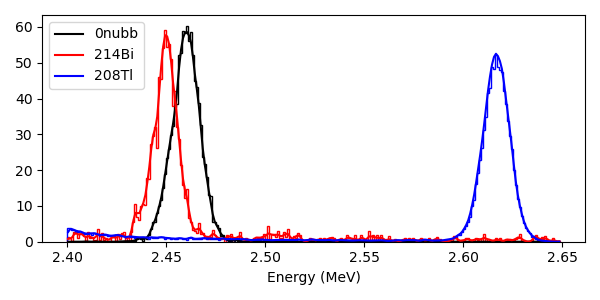

In [14]:
plt.figure(figsize=[6, 3])

# bins = np.arange(2.40, 2.65, 0.001)
# binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.loc[sel_0nubb].energy, bins=bins, density=True, histtype="step", color="k")
plt.hist(tracks_214Bi.loc[sel_214Bi].energy, bins=bins, density=True, weights=tracks_214Bi.loc[sel_214Bi].weights, histtype="step", color="r")
plt.hist(tracks_208Tl.loc[sel_208Tl].energy, bins=bins, density=True, weights=tracks_208Tl.loc[sel_208Tl].weights, histtype="step", color="b")

plt.plot(binc, pdf_energy_0nubb.pdf(binc), label="0nubb", color="k")
plt.plot(binc, pdf_energy_214Bi.pdf(binc), label="214Bi", color="r")
plt.plot(binc, pdf_energy_208Tl.pdf(binc), label="208Tl", color="b")

plt.xlabel("Energy (MeV)")
plt.legend()
plt.tight_layout()

In [15]:
sel_0nubb = sel_0nubb & tracks_0nubb.loc[sel_0nubb].energy.between(emin, emax)
sel_214Bi = sel_214Bi & tracks_214Bi.loc[sel_214Bi].energy.between(emin, emax)
sel_208Tl = sel_208Tl & tracks_208Tl.loc[sel_208Tl].energy.between(emin, emax)

### $E_{b_2}$

In [23]:
eb2bw = 0.025
eb2min, eb2max = 0., 1.20
bins = np.arange(eb2min, eb2max, eb2bw)
binc = (bins[1:] + bins[:-1])/2.
eblob2_obs = zfit.Space("eblob2", limits=(eb2min, eb2max))

h, _ = np.histogram(tracks_0nubb.loc[sel_0nubb].eblob2.values, bins=bins)
h    = hist.Hist(hist.axis.Variable(edges=bins, name="eblob2"), data=h)
pdf  = zfit.pdf.HistogramPDF(h)
data = zfit.Data.from_numpy (obs=eblob2_obs, array=binc, weights=h)
pdf_eblob2_0nubb = zfit.pdf.KDE1DimExact(obs=eblob2_obs, data=data, bandwidth=eb2bw)


h, _ = np.histogram(tracks_214Bi.loc[sel_214Bi].eblob2.values, bins=bins)
h    = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
pdf  = zfit.pdf.HistogramPDF(h)
data = zfit.Data.from_numpy (obs=eblob2_obs, array=binc, weights=h)
pdf_eblob2_214Bi = zfit.pdf.KDE1DimExact(obs=eblob2_obs, data=data, bandwidth=eb2bw)


h, _ = np.histogram(tracks_208Tl.loc[sel_208Tl].eblob2.values, bins=bins)
h    = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
pdf  = zfit.pdf.HistogramPDF(h)
data = zfit.Data.from_numpy (obs=eblob2_obs, array=binc, weights=h)
pdf_eblob2_208Tl = zfit.pdf.KDE1DimExact(obs=eblob2_obs, data=data, bandwidth=eb2bw)

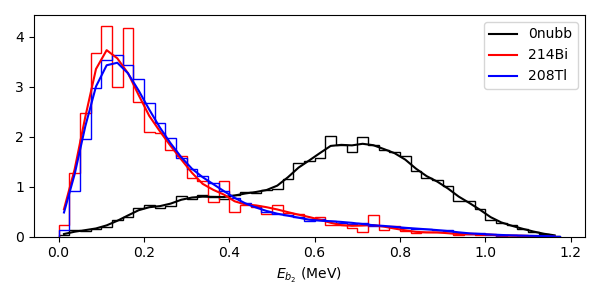

In [24]:
plt.figure(figsize=[6, 3])

# bins = np.arange(0, 1.20, bw)
# binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.loc[sel_0nubb].eblob2, bins=bins, density=True, histtype="step", color="k")
plt.hist(tracks_214Bi.loc[sel_214Bi].eblob2, bins=bins, density=True, weights=tracks_214Bi.loc[sel_214Bi].weights, histtype="step", color="r")
plt.hist(tracks_208Tl.loc[sel_208Tl].eblob2, bins=bins, density=True, weights=tracks_208Tl.loc[sel_208Tl].weights, histtype="step", color="b")

plt.plot(binc, pdf_eblob2_0nubb.pdf(binc), label="0nubb", color="k")
plt.plot(binc, pdf_eblob2_214Bi.pdf(binc), label="214Bi", color="r")
plt.plot(binc, pdf_eblob2_208Tl.pdf(binc), label="208Tl", color="b")

plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.legend()
plt.tight_layout()

In [25]:
sel_0nubb = sel_0nubb & tracks_0nubb.loc[sel_0nubb].eblob2.between(eb2min, eb2max)
sel_214Bi = sel_214Bi & tracks_214Bi.loc[sel_214Bi].eblob2.between(eb2min, eb2max)
sel_208Tl = sel_208Tl & tracks_208Tl.loc[sel_208Tl].eblob2.between(eb2min, eb2max)

## Efficiencies (energy + track + fiducial) w.r.t reco

In [26]:
eff_df = iceff_df.copy()

eff_df.loc[("0nubb", "ACTIVE"), "nevts"] = tracks_0nubb.loc[sel_0nubb].index.nunique()

a = tracks_214Bi.loc[sel_214Bi].groupby(level=2).apply(lambda df: df.index.nunique())
eff_df.loc[("214Bi", a.index), "nevts"] = a.values
a = tracks_208Tl.loc[sel_208Tl].groupby(level=2).apply(lambda df: df.index.nunique())
eff_df.loc[("208Tl", a.index), "nevts"] = a.values

eff_df = eff_df.drop(["nreco", "nsim", "exposure"], axis=1)
eff_df = eff_df.drop([("2nubb", "ACTIVE")])
eff_df = eff_df.fillna(0)
eff_df.nevts = eff_df.nevts.astype(int)

In [27]:
save_data = True
data_filename = "selected_data_typeII.h5"

if save_data:
    with tb.open_file(data_filename, mode="w", title="PDFs") as h5file:
        
        # energy
        bins = np.arange(emin, emax, ebw)
        g = h5file.create_group("/", "energy", "energy")
        h5file.create_array(g, "bins", bins, "bins")
        h, _ = np.histogram(tracks_0nubb.loc[sel_0nubb].energy.values, bins=bins)
        h5file.create_array(g, "bb0nu", h, "bb0nu")
        h, _ = np.histogram(tracks_214Bi.loc[sel_214Bi].energy.values, bins=bins)
        h5file.create_array(g, "Bi", h, "Bi")
        h, _ = np.histogram(tracks_208Tl.loc[sel_208Tl].energy.values, bins=bins)
        h5file.create_array(g, "Tl", h, "Tl")
        
        # eblob2
        bins = np.arange(eb2min, eb2max, eb2bw)
        g = h5file.create_group("/", "eblob2", "eblob2")
        h5file.create_array(g, "bins", bins, "bins")
        h, _ = np.histogram(tracks_0nubb.loc[sel_0nubb].eblob2.values, bins=bins)
        h5file.create_array(g, "bb0nu", h, "bb0nu")
        h, _ = np.histogram(tracks_214Bi.loc[sel_214Bi].eblob2.values, bins=bins)
        h5file.create_array(g, "Bi", h, "Bi")
        h, _ = np.histogram(tracks_208Tl.loc[sel_208Tl].eblob2.values, bins=bins)
        h5file.create_array(g, "Tl", h, "Tl")
        
        # efficiencies
        eff_df.to_hdf(data_filename, "efficiencies", format="table")

In [ ]:
# # binned
# bins = np.arange(2.40, 2.65, 0.005)

# # 0nubb
# h, _ = np.histogram(tracks_0nubb.loc[sel_0nubb].energy.values, bins=bins)
# h = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
# pdf_energy_0nubb = zfit.pdf.HistogramPDF(h)

# # 208Tl
# h, _ = np.histogram(tracks_208Tl.loc[sel_208Tl].energy.values, bins=bins, weights=tracks_208Tl.loc[sel_208Tl].weigths)
# h = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
# pdf_energy_208Tl = zfit.pdf.HistogramPDF(h)

# # 214Bi
# h, _ = np.histogram(tracks_214Bi.loc[sel_214Bi].energy.values, bins=bins, weights=tracks_214Bi.loc[sel_214Bi].weigths)
# h = hist.Hist(hist.axis.Variable(edges=bins, name="E"), data=h)
# pdf_energy_214Bi = zfit.pdf.HistogramPDF(h)